In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [3]:
import sys

sys.path.append('../..')

from libraries import file_management as fm

In [4]:
def resolution_function(
    true_value,
    reco_value,
):
    """
    Function to fit the resolution of the reconstruction software.
    
    Parameters:
    true_value (float): The true value of the parameter.
    reco_value (float): The reconstructed value of the parameter.

    Returns:
    The resolution of the reconstruction software.
    """

    return np.abs(reco_value - true_value) / true_value

In [17]:
def hyperbolic(
    x,
    a,
    b,
    c,
    d,
):
    return a / (b * x + c) + d  

In [6]:
if __name__ == "__main__":
    # Define the path to the ROOT file
    #path = "/sps/km3net/users/mchadoli/ANTARES/mc/cut_selection/100GeV"
    #root_file = "full_nutau_low_updated.root"
    
    path = "/sps/km3net/users/mchadoli/Swim/Data/events/ANTARES"
    root_file = "antares_w_nnfit_FINAL1.root"
    COLUMNS = [
        "interaction_type", 
        "is_cc", 
        "type",
        "energy_true",
        "cos_zenith_true",
        "NNFitTrack_Energy",
        "NNFitShower_Energy", 
        "NNFitShower_Theta",
        "NNFitTrack_Theta",
        "NNFitShower_cos_zenith",
        "NNFitTrack_cos_zenith",
        ]

    # Load the ROOT file into a DataFrame
    df = fm.load_large_rootfile_to_df(os.path.join(path, root_file), columns=COLUMNS)

    # Drop rows with Nan Values in NNFitShower
    df = df.dropna(subset=["NNFitShower_Energy"])



Loading the ROOT file: /sps/km3net/users/mchadoli/Swim/Data/events/ANTARES/antares_w_nnfit_FINAL1.root


100%|██████████| 600/600 [03:08<00:00,  3.19it/s]


ROOT file imported as a Dataframe in: 0:03:08.394708


In [7]:
df["theta_true"] = 180 - (np.arccos(df["cos_zenith_true"]) * 180 / np.pi) 

## Energy Resolution

In [8]:
def energy_resolution_fit(
    df,
):

    # Define energy bins
    energy_bins = np.round(np.geomspace(10, 100, 15), 4)
    #energy_bins = np.append(energy_bins, 1e3)

    df["energy_bins"] = pd.cut(df["energy_true"], bins= energy_bins)

    energy_resolutions = df.groupby("energy_bins").apply(
        lambda x: pd.Series(
            {
                "energy_resolution_median": x["EnergyResolution"].median(),
                "energy_resolution_std": x["EnergyResolution"].std(),
            }
        )   
    ).reset_index()


    energy_resolutions["midpoint"] = energy_resolutions["energy_bins"].apply(lambda x: x.mid)

    return energy_resolutions


/scratch/users/m/mchadoli/ipykernel_232357/2091338156.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  energy_resolutions = df.groupby("energy_bins").apply(
/scratch/users/m/mchadoli/ipykernel_232357/2091338156.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  energy_resolutions = df.groupby("energy_bins").apply(


array([<Axes: title={'center': 'EnergyResolution'}>], dtype=object)

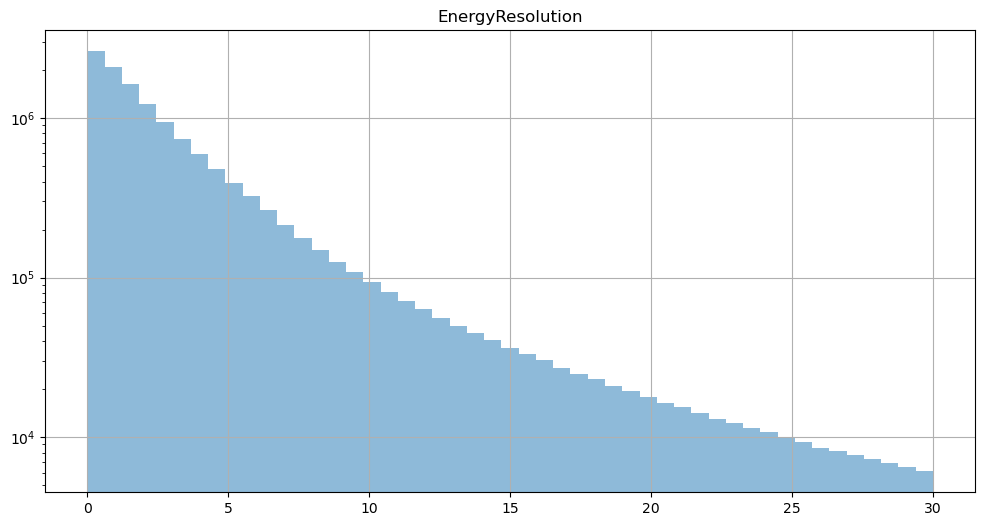

In [9]:
# Fit the energy resolutionax.set_ylabel("Energy resolution")
df["EnergyResolution"] = resolution_function(df["energy_true"], df["NNFitShower_Energy"])
energy_resolutions = energy_resolution_fit(df)

binning = np.linspace(0, 30, 50)

ax, fig = plt.subplots(figsize=(12, 6))
df.hist(
    column="EnergyResolution",
    bins=binning,
    alpha=0.5,
    label="Energy resolution",
    ax=fig,
    log=True,
)

In [22]:
# Fit the energy resolution
popt, pcov = curve_fit(
    hyperbolic,
    xdata = energy_resolutions["midpoint"].astype(float),
    ydata = energy_resolutions["energy_resolution_median"],
    sigma = energy_resolutions["energy_resolution_std"],
)
print("Error:", np.sqrt(np.diag(pcov)))

y_pred = hyperbolic(energy_resolutions["midpoint"].astype(float), *popt)

print("R2 score:", r2_score(energy_resolutions["energy_resolution_median"], y_pred))

energy_fit_params = pd.DataFrame(
    {
        "parameters": popt,
        "error": np.sqrt(np.diag(pcov)),
    })

Error: [1.18342926e+08 1.08852694e+06 3.77832261e+06 1.02287048e-01]
R2 score: 0.9991508839114595


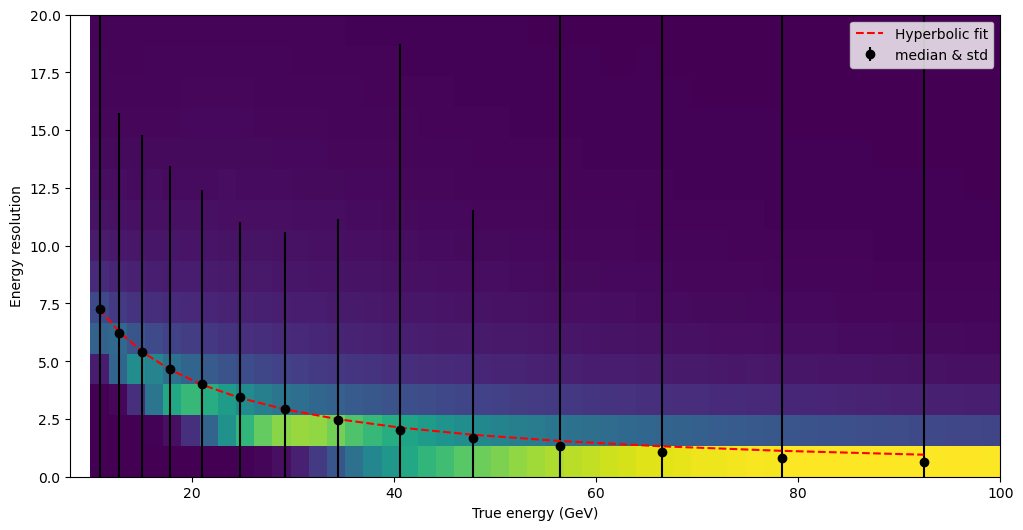

In [11]:
df_plot = df[df["EnergyResolution"] < 100]

# Apply topology function


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist2d(
    df_plot["energy_true"],
    df_plot["EnergyResolution"],
    bins=(50, 75),
    cmap="viridis",
    cmin=1,
)
ax.errorbar(
    energy_resolutions["midpoint"],
    energy_resolutions["energy_resolution_median"],
    yerr=energy_resolutions["energy_resolution_std"],
    fmt="o",
    color="black",
    label="median & std",
)
ax.plot(
    energy_resolutions["midpoint"].astype(float),
    hyperbolic(energy_resolutions["midpoint"].astype(float), *energy_fit_params["parameters"].values ),
    "--",
    color="red",
    label="Hyperbolic fit",
)
ax.set_ylim(0, 20)
ax.set_xlim(8, 100)
ax.legend()
ax.set_xlabel("True energy (GeV)")
ax.set_ylabel("Energy resolution")
plt.show()

## Direction Resolution

In [20]:
# Calculate the direction resolution
df["DirectionResolution"] = resolution_function(df["theta_true"], df["NNFitShower_Theta"])
df["DirectionResolution"] = df["DirectionResolution"].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=["DirectionResolution"], inplace=True)
df = df[df["DirectionResolution"] < 10]

direction_bins = np.arange(-1, -0.6, 0.05)
direction_bins = np.append(direction_bins, np.linspace(-0.6, 0, 7))

df["direction_bins"] = pd.cut(df["cos_zenith_true"], bins= direction_bins)

direction_resolutions = df.groupby("direction_bins").apply(
    lambda x: pd.Series(
        {
            "dir_resolution_mean": x["DirectionResolution"].mean(),
            "dir_resolution_std": x["DirectionResolution"].std(),
        }
    )
).reset_index()

direction_resolutions["midpoint"] = direction_resolutions["direction_bins"].apply(lambda x: x.mid)

# Fit the direction resolution
popt, pcov = curve_fit(
    hyperbolic,
    xdata = direction_resolutions["midpoint"].astype(float),
    ydata = direction_resolutions["dir_resolution_mean"],
    sigma = direction_resolutions["dir_resolution_std"],
)

print("Error:", np.sqrt(np.diag(pcov)))
print("R2 score:", r2_score(direction_resolutions["dir_resolution_mean"], hyperbolic(direction_resolutions["midpoint"].astype(float), *popt)))

direction_fit_params = pd.DataFrame(
    {
        "parameters": popt,
        "error": np.sqrt(np.diag(pcov)),
    })

/scratch/users/m/mchadoli/ipykernel_232357/2981173223.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  direction_resolutions = df.groupby("direction_bins").apply(


Error: [3.67896629e+08 1.14265549e+10 1.13258732e+10 2.62144237e-02]
R2 score: 0.9862860034700894


/scratch/users/m/mchadoli/ipykernel_232357/2981173223.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  direction_resolutions = df.groupby("direction_bins").apply(


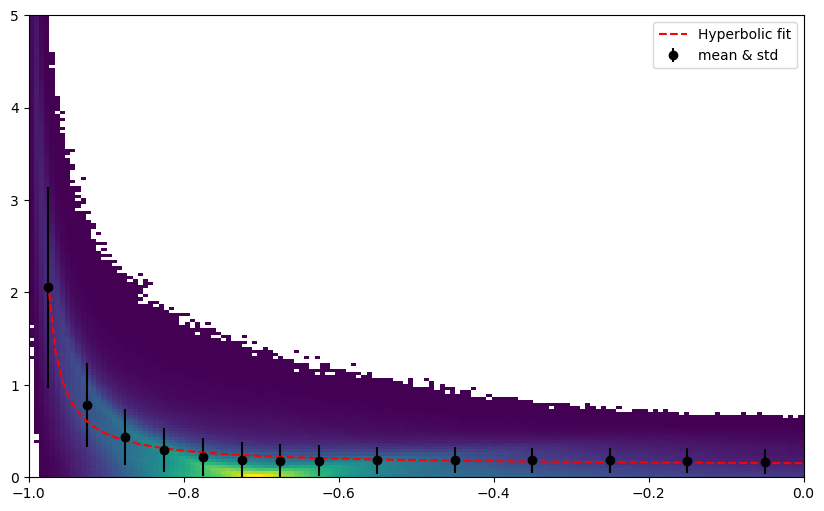

In [21]:
binning_y = np.linspace(0, 5, 150)
binning_x = np.linspace(-1, 0, 150)
x_data_dir = np.linspace(-0.975, 0, 100)


fig, ax = plt.subplots(figsize=(10, 6))
ax.hist2d(
    df["cos_zenith_true"],
    df["DirectionResolution"],
    bins= (binning_x, binning_y),
    cmap="viridis",
    cmin=10,
)
ax.errorbar(
    direction_resolutions["midpoint"],
    direction_resolutions["dir_resolution_mean"],
    yerr=direction_resolutions["dir_resolution_std"],
    fmt="o",
    color="black",
    label="mean & std",
)
ax.plot(
    x_data_dir,
    hyperbolic(x_data_dir, *direction_fit_params["parameters"].values),
    "--",
    color="red",
    label="Hyperbolic fit",
)
ax.legend()
plt.show()  

## Resolution as function of energy & direction

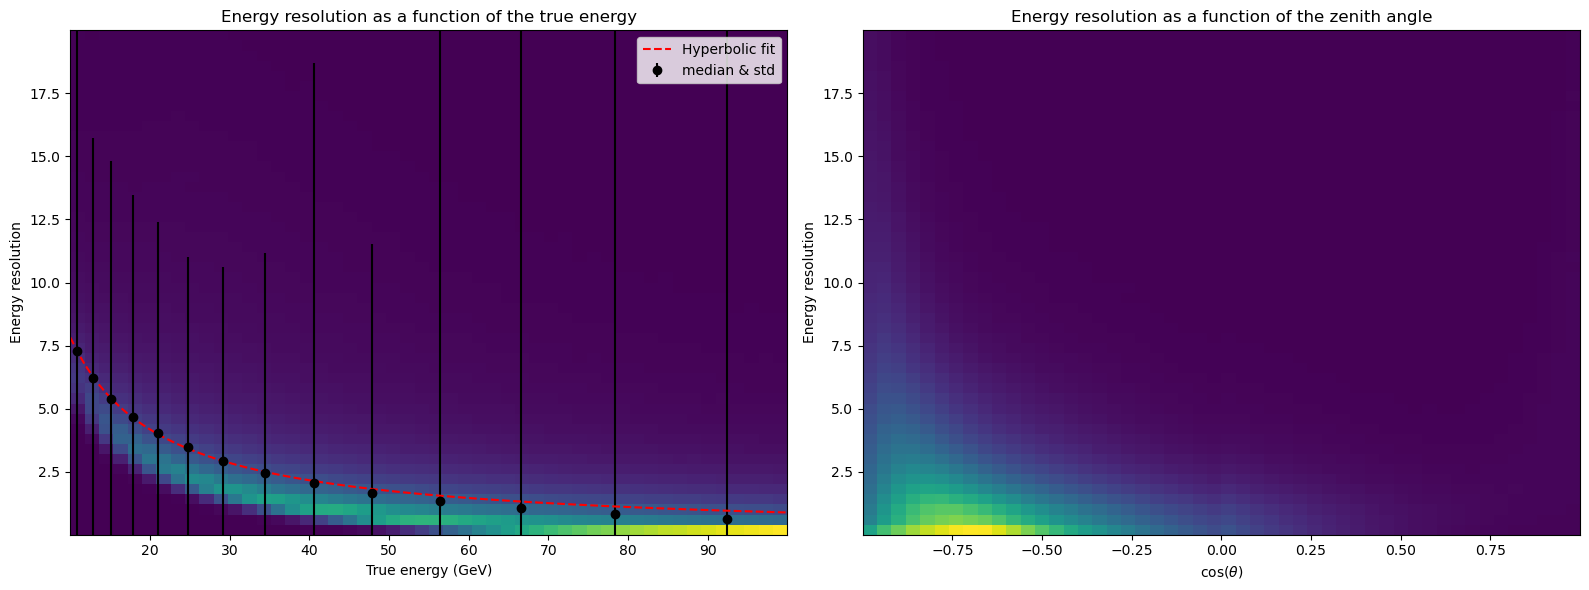

In [14]:
# Plot the energy resolution as a function of the true energy and the zenith angle
df = df[df["EnergyResolution"] < 20]
x_data_energy = np.linspace(10, 100, 100)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist2d(
    df["energy_true"],
    df["EnergyResolution"],
    bins=(50, 50),
    cmap="viridis",
    cmin=1,
)
ax[0].errorbar(
    energy_resolutions["midpoint"],
    energy_resolutions["energy_resolution_median"],
    yerr=energy_resolutions["energy_resolution_std"],
    fmt="o",
    color="black",
    label="median & std",
)
ax[0].plot(
    x_data_energy,
    hyperbolic(x_data_energy, *energy_fit_params["parameters"].values),
    "--",
    color="red",
    label="Hyperbolic fit",
)

ax[0].set_xlabel("True energy (GeV)")
ax[0].set_ylabel("Energy resolution")
ax[0].set_title("Energy resolution as a function of the true energy")
ax[1].hist2d(
    df["cos_zenith_true"],
    df["EnergyResolution"],
    bins=(50, 50),
    cmap="viridis",
    cmin=1,
)
ax[1].set_xlabel("$\cos(\\theta)$")
ax[1].set_ylabel("Energy resolution")
ax[1].set_title("Energy resolution as a function of the zenith angle")
ax[0].legend()
fig.tight_layout()
fig.savefig("../plots/energy_resolution.png")

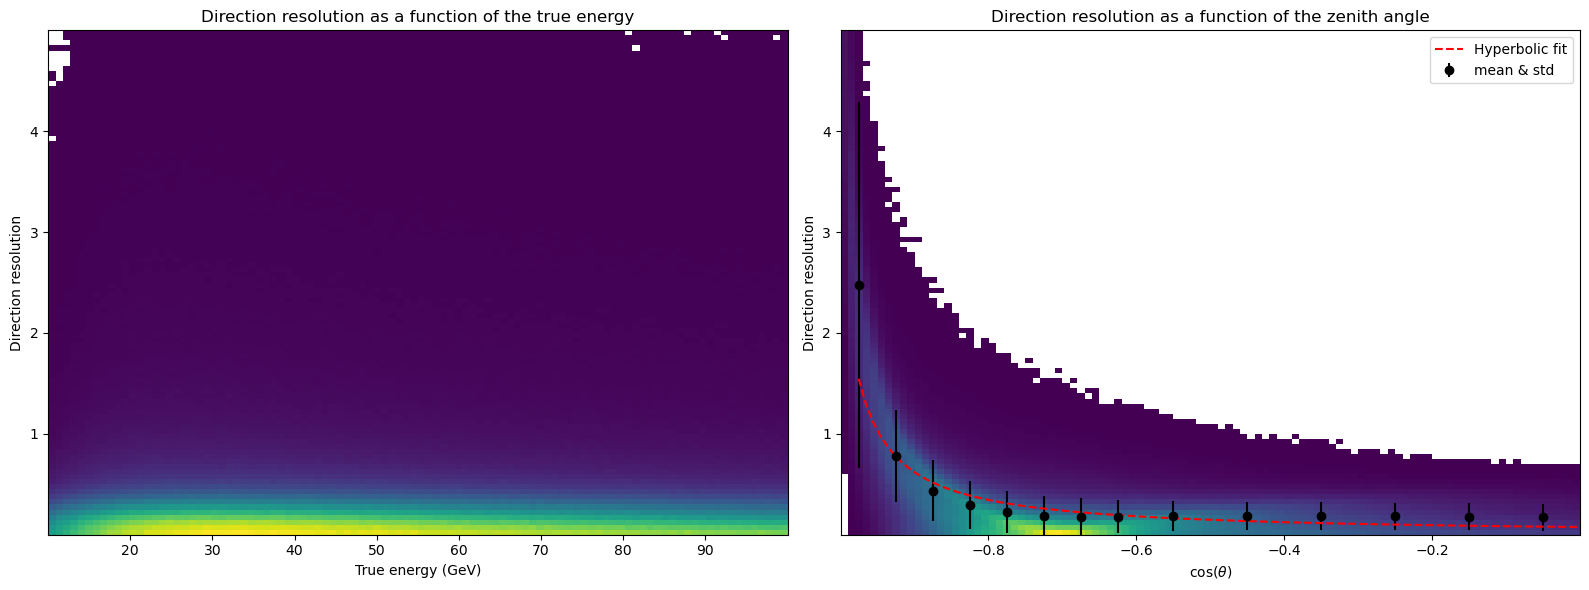

In [15]:
# Plot the direction resolution as a function of the true energy and the zenith angle
df = df[df["DirectionResolution"] < 5]
df = df[df["cos_zenith_true"] < 0]

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].hist2d(
    df["energy_true"],
    df["DirectionResolution"],
    bins=(100, 100),
    cmap="viridis",
    cmin=10,
)
ax[1].hist2d(
    df["cos_zenith_true"],
    df["DirectionResolution"],
    bins=(100, 100),
    cmap="viridis",
    cmin=10,
)
ax[1].errorbar(
    direction_resolutions["midpoint"],
    direction_resolutions["dir_resolution_mean"],
    yerr=direction_resolutions["dir_resolution_std"],
    fmt="o",
    color="black",
    label="mean & std",
)
ax[1].plot(
    x_data_dir,
    hyperbolic(x_data_dir, *direction_fit_params["parameters"].values),
    "--",
    color="red",
    label="Hyperbolic fit",
)
ax[1].legend()
ax[0].set_xlabel("True energy (GeV)")
ax[0].set_ylabel("Direction resolution")
ax[0].set_title("Direction resolution as a function of the true energy")
ax[1].set_xlabel("$\cos(\\theta)$")
ax[1].set_ylabel("Direction resolution")
ax[1].set_title("Direction resolution as a function of the zenith angle")
fig.tight_layout()
fig.savefig("../plots/direction_resolution.png")

In [25]:
# Export the resolution parameters to a CSV file
with open("../plots/resolution_parameters.csv", "w") as f:
    f.write("Energy resolution\n")
    f.write("a, b, c, d\n")
    f.write(", ".join(map(str, energy_fit_params["parameters"].values)))
    f.write("\n")
    f.write("Direction resolution\n")
    f.write(", ".join(map(str, direction_fit_params["parameters"].values)))
    f.write("\n")